<a href="https://colab.research.google.com/github/JayThibs/Weak-Supervised-Learning-Case-Study/blob/main/text_classifier/notebooks/05_toxicity_classification_snorkel_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Binary Classification Dataset of the Toxicity Dataset with Snorkel

In order to simplify the problem, we are going to turn this multi-label classification problem (does it contain any of these 'bad' labels?) to a binary classification problem (is it a 'bad' comment or not?).

We've already trained a multi-label model for this problem in notebook 01, so why are we doing this? We are doing this for a few reasons:

1. We want to test how well we can create labeling functions with Snorkel to build a dataset without knowing the labels.

2. It takes time to create many labeling functions that create a useful dataset, and it takes longer if it's for a multi-class classification problem, and even longer for multi-label classification. Therefore, in the interest of time, we will make the classification binary.

3. We want to try implementing Active Learning into our prototype and it will be simpler to start with a binary classification model.


Some of the code is borrowed from:

1. https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing#scrollTo=acF4YRlQL8iz

2. https://www.inovex.de/blog/snorkel-weak-superversion-german-texts/

3. https://trishalaneeraj.github.io/2020-07-26/data-labeling-weak-supervision

In [1]:
!pip install snorkel --quiet
!pip install datasets --quiet
!pip install spacy --quiet
!pip install pip install better-profanity --quiet

     |████████████████████████████████| 153kB 3.9MB/s 
     |████████████████████████████████| 1.8MB 25.1MB/s 
     |████████████████████████████████| 3.8MB 36.8MB/s 
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 225kB 4.1MB/s 
     |████████████████████████████████| 245kB 19.8MB/s 
     |████████████████████████████████| 112kB 20.7MB/s 
     |████████████████████████████████| 51kB 1.9MB/s 


In [2]:
import pandas as pd
from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.labeling.lf.nlp import nlp_labeling_function
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from better_profanity import profanity
from snorkel.labeling import PandasLFApplier
from sklearn.model_selection import train_test_split
import spacy
from spacy.matcher import Matcher
import numpy as np
nlp = spacy.load("en_core_web_sm")

## Data

Our dataset contains potentially offensive (toxic) comments and comes from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Let's start by download the data (from Google Drive):

In [3]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
68.8MB [00:00, 84.2MB/s]


We can take a look at the data:

In [4]:
# we can see 
df = pd.read_csv("toxic_comments.csv")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


As we can see, we have comments from YouTube videos where most are clean comments, but there are some bad comments that are labeled as either: toxic,	severe_toxic,	obscene,	threat,	insult and/or	identity_hate. We will bunch them all together into the same label we will call 'labels' because Snorkel prefers this.

## Preprocessing

Let's have a look at the dataset before we start creating labeling functions.

In [5]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((151592, 8), (7979, 8))

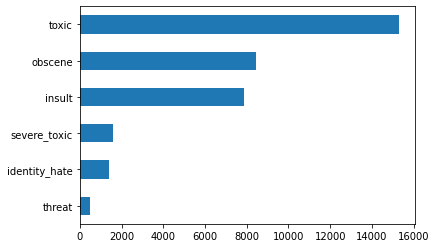

In [6]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

Now, let's add them all up together and compare them to the number of clean comments.

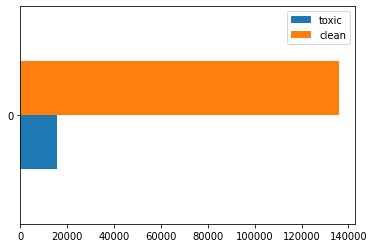

In [7]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='barh');

The bad examples are imbalanced, but we will not worry about that. What we will do, however, is to eliminate clean examples from the dataset in order to make it more balanced. We will simply reduce the number of clean comments to a number that is comparable to the toxic comments.

In [32]:
train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

train_df.shape, val_df.shape

((30463, 8), (7979, 8))

### Merging All Toxic Comments Together

In [33]:
train_df['labels'] = np.where(train_df[LABEL_COLUMNS].sum(axis=1) == 0, 0, 1)
val_df['labels'] = np.where(val_df[LABEL_COLUMNS].sum(axis=1) == 0, 0, 1)
train_df.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels
27174,47e41c90d46dda5d,"""\n\nProposed move to Social Darwinism\nHaving discussed the point here, there seems to be no reason not to move the page back to Social Darwinism to comply with the Wikipedia:Manual of Style (capital letters)#Religions, deities, philosophies, doctrines and their adherents section which concludes that """"Philosophies, theories, doctrines, and systems of thought do not begin with a capital letter, unless the name derives from a proper noun:"""". As Darwinism derives from the proper noun """"Darwin"""" it should always begin with a capital letter, thus Social Darwinism is correct. Anyone differ from this assessment? .. , talk """,0,0,0,0,0,0,0
93187,f92ad99ccff7ce2d,"In 1952 Ragual Samuel Rahator published Christology and Krishnology, a Critical Study, through Northwestern University.Christology and Krishnology, a Critical Study Northwestern University",0,0,0,0,0,0,0
131918,c1e606856701121a,"The comment about the horns was just a joke. I was just emphasizing how this article has a lot of weasel words in it that are more opinion than fact.\n\nRamdrake is shooting down everything I argue about. I'm obviously not the only person who has issues with this article. I don't see why we can't make it longer and include all of rushton's theories while also leaving plenty of room for critics. \n\nI think we should open this article up. I mean it's better if the article is twice as long and has his theories, critiques, and everything. Then everyone will be happy, but as the article stands it is just not very good. Ramdrake seems to want to have an article only on criticism, but there are many other people who would contribute more. Let's allow them to do it. I mean the article is fairly short as it is.",0,0,0,0,0,0,0
147913,43a691685854396c,You are no fun. I give up. But the edits will still remain there as my proof that I have won the war of truths against Wikipedia. 218.186.13.2,0,0,0,0,0,0,0
138974,e7be8d938a2c803f,"Notice\n\nYour attacks on Wikipedia:Suspected_sock_puppets are considered vandalism. The fact that, for the two years ending last Sunday, the account was almost entirely inactive, its only contributions being changes in spelling, pruning of video-game weapon descriptions, and racial invective, makes it suspect as a part-time puppet account, or perhaps an artificially-aged shell-identity. In the past week, it has made nearly as many edits as it had since its inception some years ago. What's more, these have caused considerable disruption in the community. I have seen this pattern of behaviour before in destructive users who are trying either to deflect guilt and reprisal from yourself onto other Wikipedians, or to make a name for a vandalism-only account by artlessly effecting a major change, such as an article deletion or a user block.\n\nBe warned that your actions have not gone unnoticed.",0,0,0,0,0,0,0


In [34]:
train_df = train_df.drop(LABEL_COLUMNS, axis=1)
val_df = val_df.drop(LABEL_COLUMNS, axis=1)
train_df

,id,comment_text,labels
134827,d11ceb3723d263bc,Blah Blah Blah. Cry me a river. Go suck a prick.,1
123055,9240c1fb4e5caf01,"""::So Hersford gets away with this? Because I stand up to this moral choice, I get fucked over with two or three warnings on my page? Instead someone doesn't warn Hersford for his bad choice? Please note his long excuse filled statement on his page. Does that not read like an attack on me? I don't like to be attacked, and he was caught for a big mistake, so instead of immediately reconsidering his mistake, he went on the attack. An age-old public relations ploy, which I don't buy. Hersford may or may not be a racist, but he certainly let an avowed racist get away with something. Sad. Talk• Contributions \n""",1
37107,630c54de93671c68,"""\n\nI JUST GAVE PROOF THEY ARE OK AND YOU BLEW ME THE HELL OFF. You are annoying me. I gave plenty of proof and you reply with an """"they are fan sites. fan sites are bad"""" answer. It is oh. so. amazing how ignored me completely. JUSTICE IS SERVED! """,1
12861,2215d63992760558,"NOT REALLY, GO AHEAD AND FUCK OFF BITCH!!!",1
64710,ad2e69231dd81818,who are you \n\nfuck?? 182.16.240.42,1
...,...,...,...
27174,47e41c90d46dda5d,"""\n\nProposed move to Social Darwinism\nHaving discussed the point here, there seems to be no reason not to move the page back to Social Darwinism to comply with the Wikipedia:Manual of Style (capital letters)#Religions, deities, philosophies, doctrines and their adherents section which concludes that """"Philosophies, theories, doctrines, and systems of thought do not begin with a capital letter, unless the name derives from a proper noun:"""". As Darwinism derives from the proper noun """"Darwin"""" it should always begin with a capital letter, thus Social Darwinism is correct. Anyone differ from this assessment? .. , talk """,0
93187,f92ad99ccff7ce2d,"In 1952 Ragual Samuel Rahator published Christology and Krishnology, a Critical Study, through Northwestern University.Christology and Krishnology, a Critical Study Northwestern University",0
131918,c1e606856701121a,"The comment about the horns was just a joke. I was just emphasizing how this article has a lot of weasel words in it that are more opinion than fact.\n\nRamdrake is shooting down everything I argue about. I'm obviously not the only person who has issues with this article. I don't see why we can't make it longer and include all of rushton's theories while also leaving plenty of room for critics. \n\nI think we should open this article up. I mean it's better if the article is twice as long and has his theories, critiques, and everything. Then everyone will be happy, but as the article stands it is just not very good. Ramdrake seems to want to have an article only on criticism, but there are many other people who would contribute more. Let's allow them to do it. I mean the article is fairly short as it is.",0
147913,43a691685854396c,You are no fun. I give up. But the edits will still remain there as my proof that I have won the war of truths against Wikipedia. 218.186.13.2,0


## Preparing the Data for Snorkel

In [35]:
train_df = train_df.rename(columns={"comment_text": "text"})
val_df = val_df.rename(columns={"comment_text": "text"})
val_df.head()

,id,text,labels
155376,bcd794ddc143f4a1,"(UTC)\n\nI wholeheartedly disagree. If you choose to annotate things using the Christian calendar, then AD should be the default. CE and BCE are and affront to the people whose calendar you're using. Use another calendar if you don't want to use the proper notation. 21:03, 11 March 2014",0
72551,c2252b14e80ca744,"Hello, please refrain from pushing your views on Wikipedia. I understand that you identify strongly with and support the values of the former illegal state: The Confederate States of America which was founded on the principals of racism and slavery. Since these are extremist and reactionary positions in our modern society, I recommend you think carefully about whether your contributions truly advance the goals of Wikipedia. Thank you.\n\nBest,\n\nAnonWikiCitizen",0
112660,5ab4d9dd112bcf08,"This is not an article about scholarship on the Cold War, but an article about the Cold War itself; scholarship of all sorts, traditional or not, should be allowed if reliable and germain.",0
115119,6786b6599e32031f,"""The problem with saying that Warren G. Harding was the first African-American President is that it is a theory that is unproven by fact. While many people believe this concept - some even go to great lengths to self publish books on the topics, there is no way to scientifically prove the concept, nor is there any way to verify generally accepted documents that could show this is even a possibility. The rumor that Harding was black rages about based on two quotes, one by Harding himself (where he says he doesn't know if it could be true, the other a rumor started by his future father-in-law meant to destroy Harding's business and reputation.) Consider verifiable these FACTS on the matter:\n1) Harding's alleged """"black"""" lineage can not be proven through United States Census forms, death certificate, or any other PRIMARY SOURCE document. As far back as the 1850 census (the first to name all people enumerated, and designate their race) Harding's father and mother are enumerated as white. This is most frequently dismissed by Harding Conspiracy followers who claim the census forms were doctored after the fact as part of a Federal Government cover-up.\n\n2) There is no DNA proof of Harding's alleged """"black blood"""", (nor is there proof that Harding fathered Elizabeth Ann Christian).\n\n3) Harding was not raised as a cultural """"black"""" that is to say that he was not raised within the black community, and therefore would have not had the same cultural experiences that other blacks in the era would have had.\n\n4) """"Black Harding"""" promoters will point to William Estabrook Chancellor's book on Harding as proof of government conspiracy. And it is interesting how swifty the government worked to squash the book and get its copies. But if one looks at Chancellor's research methodology (and we step away from those who claim that the book was supressed) - all of it based on hearsay - any student in college today who would present this type of research in the form of a paper, masters thesis or dissertation would have been thrown out of college for faulty research! \n\n5) Some of the promoters of this theory of Harding's """"blackness"""" on """"family stories"""". While folklore is not always untrue, folklore can be embellished from storyteller to storyteller. Ask anyone who studies it, folklore is at the mercy of the one who passes it on.\n\n6) The promoters of these theories go to great lengths to attack the people who poke logical holes in their wishful arguments. They can not refute the facts, so they attack the people who question their beliefs. Take a look at the """"reviews"""" of Harding books published in the past ten years in places like Amazon and B&N; online and you'll get an idea how some people will attack those who do not buy into the black """"Black Harding"""" myth.\n\nIf Wikipedia were to add information that Harding was the first black President, without irrf

## Writing Labeling Functions (LFs)

For clarity, we define constants to represent the class labels for non-toxic, toxic, and abstaining. These will go into our labeling functions so that the constants feed into the labeling process.

In [12]:
ABSTAIN = -1
NONTOXIC = 0
TOXIC = 1

In [13]:
# Useful for looking at the data and creating the labeling functions
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

Let's at a sample of the dataset so that we can come up with labeling functions.

In [14]:
train_df[train_df['labels'] == 1].sample(50, random_state=42)

,id,text,labels
23005,3cceebb6c52454bb,"George, why did you come here to tell such lies ?????\n202.92.40.8",1
14349,25eb9145e95be68e,"Ignore him, Scientizzle is just an asshole.",1
117468,73a3efe15fefcdbc,Do you give blowjob discounts to wikipedia members?,1
125202,9da308e33d31e93e,"Okay there stupid. \n\nSee those words there in brackets.\n\nThose are the source.\n\nSee that, there is a little reference (TORAH, TANAKH). for you. It's online! I'm gathering the rest. So just chillax with your impetuous stupidity.\n\nI even spelled out the chapter, and the verse for you. EVEN GAVE THE BOOK(S) THEY WERE CONTAINED IN.",1
121626,8abf6aec0a13bcf9,"Audi A4\nYOU ARE ASSHOLE, MOTHERFUCKER, SHIT, FUCK, ASSHOLE. (talk • contributions)",1
71551,bf8b1e93498277af,stupid sit i will behead you,1
78727,d29ea4ec66b1b882,And why the fuck should i care? \n\n67.165.71.214,1
122226,8dd9ff726e894b47,how dare u you german piece of dog shit \n\ndont u fucking clear my edit ever again u piece of horse shit faggot,1
51115,88bcdab667d66d10,User:abd is Muslim Scum,1
23695,3e97450e9f97f1d3,"In general, I'm sick of your obnoxious excuses and immature piling-up. This will be all. — | talk",1


In [15]:
# Showing the most common words to make the labeling function creation process quicker
# This is where we can come up with a custom keyword list

pd.Series(' '.join(train_df[train_df['labels'] == 1].sample(50, random_state=42).text).split()).value_counts()[:50]

the           55
YOU           42
you           36
to            35
a             30
of            30
is            30
I             28
and           25
FUCK          19
THAT          19
SO            19
FOR           17
FACISTS       17
SUPRESSING    17
that          17
on            15
it            13
not           13
your          13
my            11
with          11
in            11
fucking       11
You           10
have          10
are           10
"              9
I'm            9
me             9
at             8
like           8
be             8
for            7
he             7
should         7
this           7
did            7
This           7
there          7
been           6
just           6
u              6
because        6
so             6
by             6
his            6
i              6
get            5
edit           5
dtype: int64

### Labeling Functions

In [16]:
@nlp_labeling_function()
def contains_work_of_art(x):
    """If comment contains titles of books, songs, etc., label non-toxic, else abstain"""
    if any([ent.label_ == "WORK_OF_ART" for ent in x.doc.ents]):
        return NONTOXIC
    else:
        return ABSTAIN
    
@nlp_labeling_function()
def contains_entity(x):
    """If comment contains least 3 mentions of an entity, label non-toxic, else abstain"""
    if len([ent.label_ in ["PERSON", "GPE", "LOC", "ORG", "LAW", "LANGUAGE"] for ent in x.doc.ents])>2:
        return NONTOXIC
    else:
        return ABSTAIN

In [17]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    """If comment has a polarity score between +0.9 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    """If comment has a subjectivity score between +0.7 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.subjectivity >= 0.7 else ABSTAIN

In [18]:
# @labeling_function()
# def contains_profanity(x):
#     """
#     If comment contains profanity label toxic, else abstain. 
#     Profanity determined using this library - https://github.com/snguyenthanh/better_profanity
#     """
#     return TOXIC if profanity.contains_profanity(x.text) else ABSTAIN

In [19]:
nlp = spacy.load("en_core_web_sm")

# @nlp_labeling_function()
# def contains_pleaseread(x):
#     """
#     Will match commonly occuring phrases like - 
#     Please read this
#     Please read the
#     Please read
#     """
#     matcher = PhraseMatcher(nlp.vocab)
#     pattern = [{"LEMMA": "please"},
#                {"LEMMA": "read"},
#                {"LEMMA": "the", "OP": "?"},
#                {"LEMMA": "this", "OP": "?"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

@nlp_labeling_function()
def contains_stopvandalizing(x):
    """
    Will match commonly occuring phrases like - 
    stop vandalizing
    do not vandalize
    don't vandalize
    """
    matcher = PhraseMatcher(nlp.vocab)
    pattern1 = ["do not vandalize", 'vandalize']
    pattern2 = [{"LEMMA": "stop"}, 
                {"LEMMA": "vandalize"}]
    matcher.add("p1", None, pattern1)
    matcher.add("p2", None, pattern2)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
# @nlp_labeling_function()
# def contains_harassme(x):
#     """
#     Will match commonly occuring phrases like - 
#     harass me
#     harassed me
#     harassing me
#     """
#     matcher = Matcher(nlp.vocab)
#     pattern = [{"LOWER": "harass"}, 
#                {"LOWER": "me"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

# @nlp_labeling_function()
# def contains_willreport(x):
#     """Will match commonly observed phrases like - 
#     report you
#     reported you
#     reporting you
#     reported your
#     """
#     matcher = Matcher(nlp.vocab)
#     pattern = [{"LEMMA": "report"}, 
#                {"LEMMA": "you"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

In [20]:
@nlp_labeling_function()
def contains_email(x):
    """If comment contains email address, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_EMAIL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
@nlp_labeling_function()
def contains_url(x):
    """If comment contains url, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_URL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN

In [23]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=TOXIC):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

# with open('badwords.txt') as f:
#     toxic_stopwords = f.readlines()

# toxic_stopwords = [x.strip() for x in toxic_stopwords] # len = 458
# """Comments mentioning at least one of Google's Toxic Stopwords 
# https://code.google.com/archive/p/badwordslist/downloads are likely toxic"""
# keyword_toxic_stopwords = make_keyword_lf(keywords=toxic_stopwords)

keyword_please = make_keyword_lf(keywords=["please", "plz", "pls", "pl", "Please read this", "Please read the", "Please read"], label=NONTOXIC)

keyword_thanks = make_keyword_lf(keywords=["thanks", "thank you", "thx", "tx"], label=NONTOXIC)

In [24]:
@labeling_function()
def capslock(x):
    """If comment is written in all caps, label toxic, else abstain"""
    return TOXIC if x.text == x.text.upper() else ABSTAIN

In [25]:
lfs = [
      contains_work_of_art,
      contains_entity,
      textblob_polarity,
      textblob_subjectivity,
      # contains_profanity,       # Removed: 62% accuracy, removed to make labeling faster
      # contains_pleaseread,
      contains_stopvandalizing,
      # contains_harassme,        # Removed: 50% on 4 examples
      # contains_willreport,      # Removed: labels 1 example and gets it wrong
      contains_email,
      contains_url,
      # keyword_toxic_stopwords,  # Removed: 22% accuracy
      keyword_please,
      keyword_thanks,
      # capslock                  # Removed: 55% accuracy, doesn't label many examples
]

## Applying the Labeling Functions

In [26]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train_df)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 30463/30463 [26:58<00:00, 18.82it/s]


In [38]:
L_val = applier.apply(df=val_df)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 7979/7979 [07:14<00:00, 18.38it/s]


In [27]:
import pickle

with open('L_train_toxic_1.pkl','wb') as f:
  pickle.dump(L_train, f)
with open('L_train_toxic_1.pkl','rb') as f:
  L_train = pickle.load(f)
  print(L_train.shape)

(30463, 10)


In [28]:
L_train

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  0, -1, ..., -1,  0, -1],
       [-1, -1, -1, ..., -1,  0, -1],
       ...,
       [-1,  0, -1, ..., -1,  0, -1],
       [-1,  0, -1, ..., -1,  0,  0],
       [-1, -1, -1, ..., -1,  0, -1]])

In [29]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
contains_work_of_art,0,[0],0.059843,0.053409,0.0
contains_entity,1,[0],0.298001,0.205922,0.0
textblob_polarity,2,[0],0.003709,0.002725,0.0
textblob_subjectivity,3,[0],0.171224,0.058563,0.0
contains_pleaseread,4,[0],0.002692,0.002692,0.0
contains_stopvandalizing,5,[0],0.004432,0.004038,0.0
contains_email,6,[0],0.001805,0.001444,0.0
contains_url,7,[0],0.030956,0.024719,0.0
keyword_please,8,[0],0.322588,0.214391,0.0
keyword_thanks,9,[0],0.080097,0.057053,0.0


In [30]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [31]:
val_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
155376,bcd794ddc143f4a1,"(UTC)\n\nI wholeheartedly disagree. If you choose to annotate things using the Christian calendar, then AD should be the default. CE and BCE are and affront to the people whose calendar you're using. Use another calendar if you don't want to use the proper notation. 21:03, 11 March 2014",0,0,0,0,0,0
72551,c2252b14e80ca744,"Hello, please refrain from pushing your views on Wikipedia. I understand that you identify strongly with and support the values of the former illegal state: The Confederate States of America which was founded on the principals of racism and slavery. Since these are extremist and reactionary positions in our modern society, I recommend you think carefully about whether your contributions truly advance the goals of Wikipedia. Thank you.\n\nBest,\n\nAnonWikiCitizen",0,0,0,0,0,0
112660,5ab4d9dd112bcf08,"This is not an article about scholarship on the Cold War, but an article about the Cold War itself; scholarship of all sorts, traditional or not, should be allowed if reliable and germain.",0,0,0,0,0,0
115119,6786b6599e32031f,"""The problem with saying that Warren G. Harding was the first African-American President is that it is a theory that is unproven by fact. While many people believe this concept - some even go to great lengths to self publish books on the topics, there is no way to scientifically prove the concept, nor is there any way to verify generally accepted documents that could show this is even a possibility. The rumor that Harding was black rages about based on two quotes, one by Harding himself (where he says he doesn't know if it could be true, the other a rumor started by his future father-in-law meant to destroy Harding's business and reputation.) Consider verifiable these FACTS on the matter:\n1) Harding's alleged """"black"""" lineage can not be proven through United States Census forms, death certificate, or any other PRIMARY SOURCE document. As far back as the 1850 census (the first to name all people enumerated, and designate their race) Harding's father and mother are enumerated as white. This is most frequently dismissed by Harding Conspiracy followers who claim the census forms were doctored after the fact as part of a Federal Government cover-up.\n\n2) There is no DNA proof of Harding's alleged """"black blood"""", (nor is there proof that Harding fathered Elizabeth Ann Christian).\n\n3) Harding was not raised as a cultural """"black"""" that is to say that he was not raised within the black community, and therefore would have not had the same cultural experiences that other blacks in the era would have had.\n\n4) """"Black Harding"""" promoters will point to William Estabrook Chancellor's book on Harding as proof of government conspiracy. And it is interesting how swifty the government worked to squash the book and get its copies. But if one looks at Chancellor's research methodology (and we step away from those who claim that the book was supressed) - all of it based on hearsay - any student in college today who would present this type of research in the form of a paper, masters thesis or dissertation would have been thrown out of college for faulty research! \n\n5) Some of the promoters of this theory of Harding's """"blackness"""" on """"family stories"""". While folklore is not always untrue, folklore can be embellished from storyteller to storyteller. Ask anyone who studies it, folklore is at the mercy of the one who passes it on.\n\n6) The promoters of these theories go to great lengths to attack the people who poke logical holes in their wishful arguments. They can not refute the facts, so they attack the people who question their beliefs. Take a look at the """"reviews"""" of Harding books published in the past ten years in places like Amazon and B&N; online and you'll get an idea how some people will attack those who do not buy into the black """"Black Harding"""" myth.\n\nIf Wiki

In [45]:
Y_val = val_df.labels.values
LFAnalysis(L_val, lfs).lf_summary(Y_val)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
contains_work_of_art,0,[0],0.079208,0.070811,0.0,605,27,0.957278
contains_entity,1,[0],0.361073,0.255420,0.0,2719,162,0.943770
textblob_polarity,2,[0],0.005640,0.003760,0.0,43,2,0.955556
textblob_subjectivity,3,[0],0.112044,0.052262,0.0,706,188,0.789709
contains_pleaseread,4,[0],0.003509,0.003509,0.0,28,0,1.000000
contains_stopvandalizing,5,[0],0.004888,0.004387,0.0,38,1,0.974359
contains_email,6,[0],0.001880,0.001504,0.0,15,0,1.000000
contains_url,7,[0],0.039855,0.031959,0.0,309,9,0.971698
keyword_please,8,[0],0.391277,0.270836,0.0,2940,182,0.941704
keyword_thanks,9,[0],0.120566,0.084346,0.0,940,22,0.977131


In [50]:
correct_examples = LFAnalysis(L_val, lfs).lf_summary(Y_val)['Correct'].sum()
incorrect_examples = LFAnalysis(L_val, lfs).lf_summary(Y_val)['Incorrect'].sum()
total_examples = correct_examples + incorrect_examples

print('Number of Correct Examples: ' + str(correct_examples))
print('Number of Correct Examples: ' + str(incorrect_examples))
print('Percentage of Correct Examples: ' + str(100 * correct_examples / total_examples) + '%')

Number of Correct Examples: 8343
Number of Correct Examples: 593
Percentage of Correct Examples: 93.363921217547%


In [51]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 3))

In [53]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)

In [58]:
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
snorkel_label_probs = label_model.predict_proba(L=L_train)
X, y = filter_unlabeled_dataframe(X=train_df.text, y=snorkel_label_probs, L=L_train)
X = vectorizer.fit_transform(X)
classifier.fit(X, probs_to_preds(probs=y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [61]:
X = vectorizer.transform(val_df.text.tolist())
y_true = val_df.labels.values    
y_pred = classifier.predict(X)

'              precision    recall  f1-score   support\n\n           0       0.92      1.00      0.96      7217\n           1       0.91      0.19      0.31       762\n\n    accuracy                           0.92      7979\n   macro avg       0.92      0.59      0.63      7979\nweighted avg       0.92      0.92      0.90      7979\n'

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7217
           1       0.91      0.19      0.31       762

    accuracy                           0.92      7979
   macro avg       0.92      0.59      0.63      7979
weighted avg       0.92      0.92      0.90      7979

